In [39]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [40]:
!pip -q install feast scikit-learn pandas matplotlib seaborn codecarbon

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 610.1/610.1 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.0/278.0 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 34.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.5/92.5 kB 4.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-genai 1.24.0 requires httpx<1.0.0,>=0.28.1, but you have httpx 0.27.2 which is incompatible.
firebase-admin 6.9.0 requires httpx[http2]==0.28.1, but you have httpx 0.27.2 which is incompatible.


In [41]:
!feast init feature_repo

2025-07-13 22:38:01.490680: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752446281.539417   70087 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752446281.556693   70087 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
The directory feature_repo contains an existing feature store repository that may cause a conflict



# 1. Load and Prepare Data



In [42]:
import pandas as pd

file_path = '/content/drive/MyDrive/MLOPS/data/athletes.csv'

df = pd.read_csv(file_path)

print("Data loaded successfully from Google Drive!")

Data loaded successfully from Google Drive!


In [43]:
import numpy as np

# clean the dataset
df = df.dropna(subset=['region','age','weight','height','howlong','gender','eat',
                           'train','background','experience','schedule','howlong',
                           'deadlift','candj','snatch','backsq','experience',
                           'background','schedule','howlong'])
df = df.drop(columns=['affiliate','team','name','athlete_id','fran','helen','grace',
                          'filthy50','fgonebad','run400','run5k','pullups','train'])

# Remove Outliers

df = df[df['weight'] < 1500]
df = df[df['gender'] != '--']
df = df[df['age'] >= 18]
df = df[(df['height'] < 96) & (df['height'] > 48)]

df = df[(df['deadlift'] > 0) & (df['deadlift'] <= 1105)|((df['gender'] == 'Female')
            & (df['deadlift'] <= 636))]
df = df[(df['candj'] > 0) & (df['candj'] <= 395)]
df = df[(df['snatch'] > 0) & (df['snatch'] <= 496)]
df = df[(df['backsq'] > 0) & (df['backsq'] <= 1069)]

# Clean Survey Data

decline_dict = {'Decline to answer|': np.nan}
df = df.replace(decline_dict)
df = df.dropna(subset=['background','experience','schedule','howlong','eat'])


In [44]:
# --- 1. Select Target and Feature Columns ---
lift_columns = ['candj', 'snatch', 'deadlift', 'backsq']
df['total_lift'] = df[lift_columns].sum(axis=1)
target_column = 'total_lift'

feature_columns = ['gender', 'age', 'height', 'weight', 'candj', 'snatch', 'deadlift', 'backsq', 'region']

# Create a new DataFrame with only the columns we need
df_processed = df[feature_columns + [target_column]].copy()

print(df_processed.head())

# --- Save the final dataframe to a new parquet file for Feast
df.to_parquet("athletes_data.parquet")
df.to_csv("athletes_data.csv")
print("Successfully converted 'athletes_data.csv' to 'athletes_data.parquet'")

   gender   age  height  weight  candj  snatch  deadlift  backsq  \
21   Male  30.0    71.0   200.0  235.0   175.0     385.0   315.0   
22   Male  28.0    70.0   176.0  187.0   134.0     335.0   254.0   
27   Male  35.0    68.0   225.0  285.0   205.0     440.0   405.0   
50   Male  36.0    71.0   199.0  267.0   212.0     485.0   390.0   
60   Male  36.0    64.0   155.0  245.0   180.0     415.0   385.0   

                 region  total_lift  
21  Southern California      1110.0  
22               Africa       910.0  
27           North East      1335.0  
50        North Central      1354.0  
60           North East      1225.0  
Successfully converted 'athletes_data.csv' to 'athletes_data.parquet'


# 2. Define Features in Feast

In [45]:
%%writefile feature_repo/feature_definition.py

from datetime import timedelta
# Imports are simpler now
from feast import (
    Entity,
    FeatureView,
    Field,
    FileSource,
    ValueType,
)
from feast.types import Float32, Int64, String

# Entity remains the same
athlete = Entity(name="athlete_id", join_keys=["athlete_id"])

# The FileSource now points to the .parquet file and needs no format specified
file_source = FileSource(
    path="/content/athletes_data.parquet",  # <-- Point to the new .parquet file
    timestamp_field="event_timestamp",
)

# The rest of your definitions remain the same
athlete_v1_view = FeatureView(
    name="athlete_v1_view",
    entities=[athlete],
    ttl=timedelta(days=365),
    schema=[
        Field(name="height", dtype=Float32),
        Field(name="weight", dtype=Float32),
        Field(name="age", dtype=Int64),
        Field(name="gender", dtype=String),
        Field(name="region", dtype=String),
    ],
    source=file_source,
)

athlete_v2_view = FeatureView(
    name="athlete_v2_view",
    entities=[athlete],
    ttl=timedelta(days=365),
    schema=[
        Field(name="bmi", dtype=Float32),
        Field(name="age", dtype=Int64),
        Field(name="gender", dtype=String),
        Field(name="region", dtype=String),
    ],
    source=file_source,
)

Overwriting feature_repo/feature_definition.py


In [46]:
%%writefile feature_repo/feature_store.yaml
project: feature_repo
registry: data/registry.db
provider: local
online_store:
    type: sqlite
    path: data/online_store.db

Overwriting feature_repo/feature_store.yaml


In [47]:
!rm /content/feature_repo/feature_repo/example_repo.py

rm: cannot remove '/content/feature_repo/feature_repo/example_repo.py': No such file or directory


In [48]:
!cd feature_repo && feast apply

2025-07-13 22:38:35.033315: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752446315.074276   70275 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752446315.087134   70275 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/content/feature_repo/feature_definition.py:14: DeprecationWarning: Entity value_type will be mandatory in the next release. Please specify a value_type for entity 'athlete_id'.
  athlete = Entity(name="athlete_id", join_keys=["athlete_id"])
No project found in the repository. Using project name feature_repo defined in feature_store.yaml
Applying changes for project feature_repo
/usr/local/lib/python3.11/dist-packages/feast/feature_v

# 3. Generating Training Dataset from Feast

In [49]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# 1. Load the dataset you created
df = pd.read_csv("athletes_data.csv")

# ==============================================================================
# --- Create Feature Set V1 ---
# ==============================================================================
# We still need the basic encoded columns for both versions
df_v1 = df.copy()

encoder = LabelEncoder()
df_v1['gender_encoded'] = encoder.fit_transform(df_v1['gender'])

# One-Hot Encode the 'region' feature
region_dummies = pd.get_dummies(df_v1['region'], prefix='region', dtype=int)
df_v1 = pd.concat([df_v1, region_dummies], axis=1)

# Select the final features for V1
features_v1 = df_v1[['age', 'height', 'weight', 'gender_encoded'] + list(region_dummies.columns)]


target_v1 = df['total_lift']


# ==============================================================================
# --- Create New and Improved Feature Set V2 ---
# ==============================================================================
# --- Create New and Improved Feature Set V2 (with BMI) ---

# Start with a fresh copy of the dataframe
df_v2 = df.copy()

# 1. Bin the 'age' feature into categories
df_v2['age_group'] = pd.cut(df_v2['age'],
                          bins=[0, 24, 30, 100],
                          labels=['24_and_under', '25_to_30', '31_and_over'])

# 2. Create an interaction feature for height and weight
df_v2['height_x_weight'] = df_v2['height'] * df_v2['weight']

# 3. Create the BMI feature
# Note: Assuming height is in inches and weight is in lbs for BMI calculation
df_v2['bmi'] = (df_v2['weight'] * 0.453592) / ((df_v2['height'] * 0.0254) ** 2)

# 4. One-Hot Encode the 'region' feature
region_dummies = pd.get_dummies(df_v2['region'], prefix='region', dtype=int)
df_v2 = pd.concat([df_v2, region_dummies], axis=1)

# 5. LabelEncode the new 'age_group' and original 'gender' columns
age_group_encoder = LabelEncoder()
gender_encoder = LabelEncoder()
df_v2['age_group_encoded'] = age_group_encoder.fit_transform(df_v2['age_group'])
df_v2['gender_encoded'] = gender_encoder.fit_transform(df_v2['gender'])


# 6. Select the final features for V2, now including BMI
features_v2 = df_v2[
    ['age_group_encoded', 'height', 'weight','height_x_weight', 'bmi', 'gender_encoded'] + list(region_dummies.columns)
]
target_v2 = df_v2['total_lift']



# --- Final Output ---
print("--- V1 Features Ready for Model ---")
print(features_v1.head())
print("\n--- New and Improved V2 Features Ready for Model ---")
print(features_v2.head())

--- V1 Features Ready for Model ---
    age  height  weight  gender_encoded  region_Africa  region_Asia  \
0  30.0    71.0   200.0               1              0            0   
1  28.0    70.0   176.0               1              1            0   
2  35.0    68.0   225.0               1              0            0   
3  36.0    71.0   199.0               1              0            0   
4  36.0    64.0   155.0               1              0            0   

   region_Australia  region_Canada East  region_Canada West  \
0                 0                   0                   0   
1                 0                   0                   0   
2                 0                   0                   0   
3                 0                   0                   0   
4                 0                   0                   0   

   region_Central East  ...  region_Latin America  region_Mid Atlantic  \
0                    0  ...                     0                    0   
1         

# 4. Run Experiments

In [51]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from codecarbon import EmissionsTracker

import os
os.makedirs("emissions_log", exist_ok=True)

# 1. Define your training function
def train_and_evaluate_regressor(features, target, hyperparameters):
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)
    model = RandomForestRegressor(**hyperparameters, random_state=42)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    r2 = r2_score(y_test, predictions)
    return {'rmse': rmse, 'r2_score': r2}, model

# 2. Define your experiment combinations
experiment_datasets = {
    'v1': (features_v1, target_v1),
    'v2': (features_v2, target_v2)
}
hyperparameter_sets = {
    'hp1': {'n_estimators': 100, 'max_depth': 10},
    'hp2': {'n_estimators': 200, 'max_depth': 20}
}

# 3. Run the experiment loop
experiment_log = []
trained_models = {}

for version_name, (features, target) in experiment_datasets.items():
    for hp_name, params in hyperparameter_sets.items():
        run_name = f"{version_name}_{hp_name}"
        print(f"\n🔁 Running experiment: {run_name}...")

        tracker = EmissionsTracker(project_name="athlete_model_training", output_dir="emissions_log", output_file=f"{run_name}_emissions.csv")
        tracker.start()

        metrics, model = train_and_evaluate_regressor(features, target, params)

        emissions = tracker.stop()

        log_entry = {
            'run_name': run_name,
            'feature_version': version_name,
            'hyperparameters': hp_name,
            'rmse': metrics['rmse'],
            'r2_score': metrics['r2_score'],
            'emissions_kg': emissions  # Unit: kg CO₂
        }
        experiment_log.append(log_entry)
        trained_models[run_name] = model


[codecarbon WARNING @ 22:39:51] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 22:39:51] [setup] RAM Tracking...
[codecarbon INFO @ 22:39:51] [setup] CPU Tracking...



🔁 Running experiment: v1_hp1...


[codecarbon WARNING @ 22:39:53] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 22:39:53] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 22:39:53] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 22:39:53] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 22:39:53] [setup] GPU Tracking...
[codecarbon INFO @ 22:39:53] No GPU found.
[codecarbon INFO @ 22:39:53] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 22:39:53] >>> Tracker's metadata:
[codecarbon INFO @ 22:39:53]   Platform system: Linux-6


🔁 Running experiment: v1_hp2...


[codecarbon WARNING @ 22:40:01] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 22:40:01] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 22:40:01] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 22:40:01] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 22:40:01] [setup] GPU Tracking...
[codecarbon INFO @ 22:40:01] No GPU found.
[codecarbon INFO @ 22:40:01] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 22:40:01] >>> Tracker's metadata:
[codecarbon INFO @ 22:40:01]   Platform system: Linux-6


🔁 Running experiment: v2_hp1...


[codecarbon WARNING @ 22:40:23] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 22:40:23] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 22:40:23] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 22:40:23] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 22:40:23] [setup] GPU Tracking...
[codecarbon INFO @ 22:40:23] No GPU found.
[codecarbon INFO @ 22:40:23] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 22:40:23] >>> Tracker's metadata:
[codecarbon INFO @ 22:40:23]   Platform system: Linux-6


🔁 Running experiment: v2_hp2...


[codecarbon WARNING @ 22:40:33] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 22:40:33] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 22:40:33] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 22:40:33] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 22:40:33] [setup] GPU Tracking...
[codecarbon INFO @ 22:40:33] No GPU found.
[codecarbon INFO @ 22:40:33] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 22:40:33] >>> Tracker's metadata:
[codecarbon INFO @ 22:40:33]   Platform system: Linux-6

# 5. Quantitative Comparison

In [52]:
results_df = pd.DataFrame(experiment_log)
print("\n--- Quantitative Experiment Results Table ---")
print(results_df)


--- Quantitative Experiment Results Table ---
  run_name feature_version hyperparameters        rmse  r2_score  emissions_kg
0   v1_hp1              v1             hp1  166.199365  0.638991      0.000031
1   v1_hp2              v1             hp2  173.054285  0.608597      0.000102
2   v2_hp1              v2             hp1  169.324394  0.625287      0.000043
3   v2_hp2              v2             hp2  177.225807  0.589500      0.000157


# 6. Qualitative Comparison

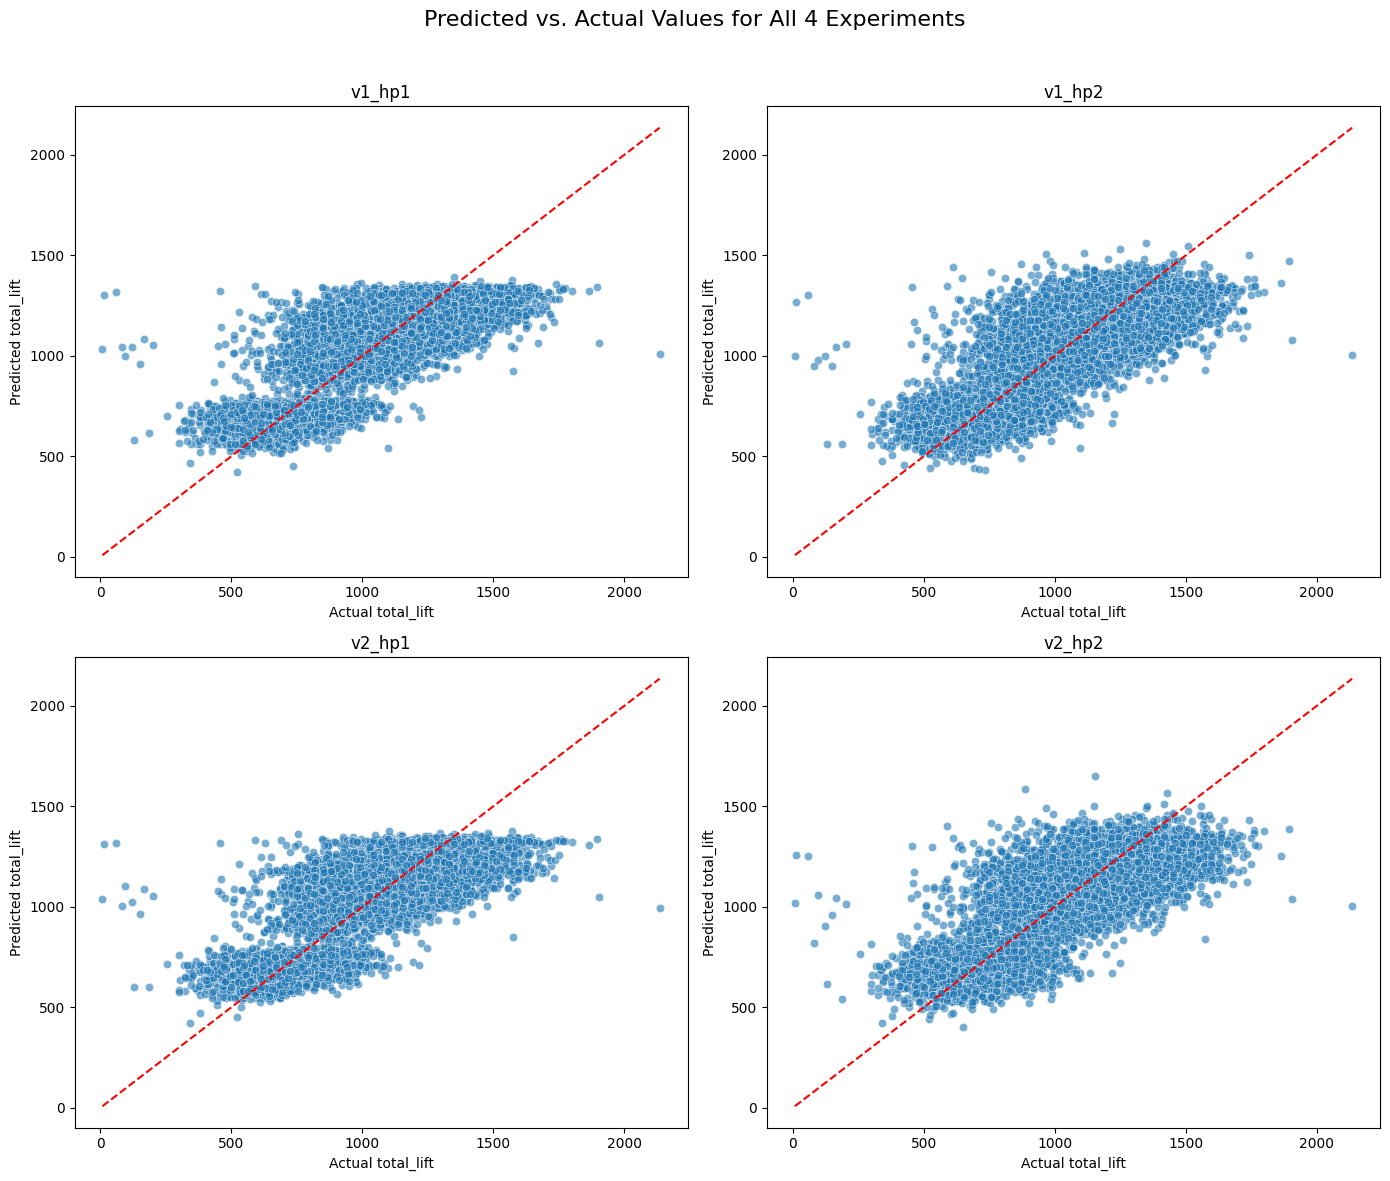

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# Create a 2x2 grid for the plots
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
fig.suptitle('Predicted vs. Actual Values for All 4 Experiments', fontsize=16)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through each of your experiment results
for i, run in results_df.iterrows():
    run_name = run['run_name']

    # Get the correct model and dataset for this run
    model = trained_models[run_name]
    features, target = experiment_datasets[run['feature_version']]

    # We must split the data again with the same random_state to get the correct test set
    _, X_test, _, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

    # Make predictions on the test set
    predictions = model.predict(X_test)

    # Create the scatter plot on the correct subplot
    sns.scatterplot(x=y_test, y=predictions, ax=axes[i], alpha=0.6)
    axes[i].set_title(run_name)
    axes[i].set_xlabel("Actual total_lift")
    axes[i].set_ylabel("Predicted total_lift")

    # Add the 45-degree line for reference
    min_val = min(y_test.min(), predictions.min())
    max_val = max(y_test.max(), predictions.max())
    axes[i].plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('predicted_vs_actual_comparison.png')
plt.show()

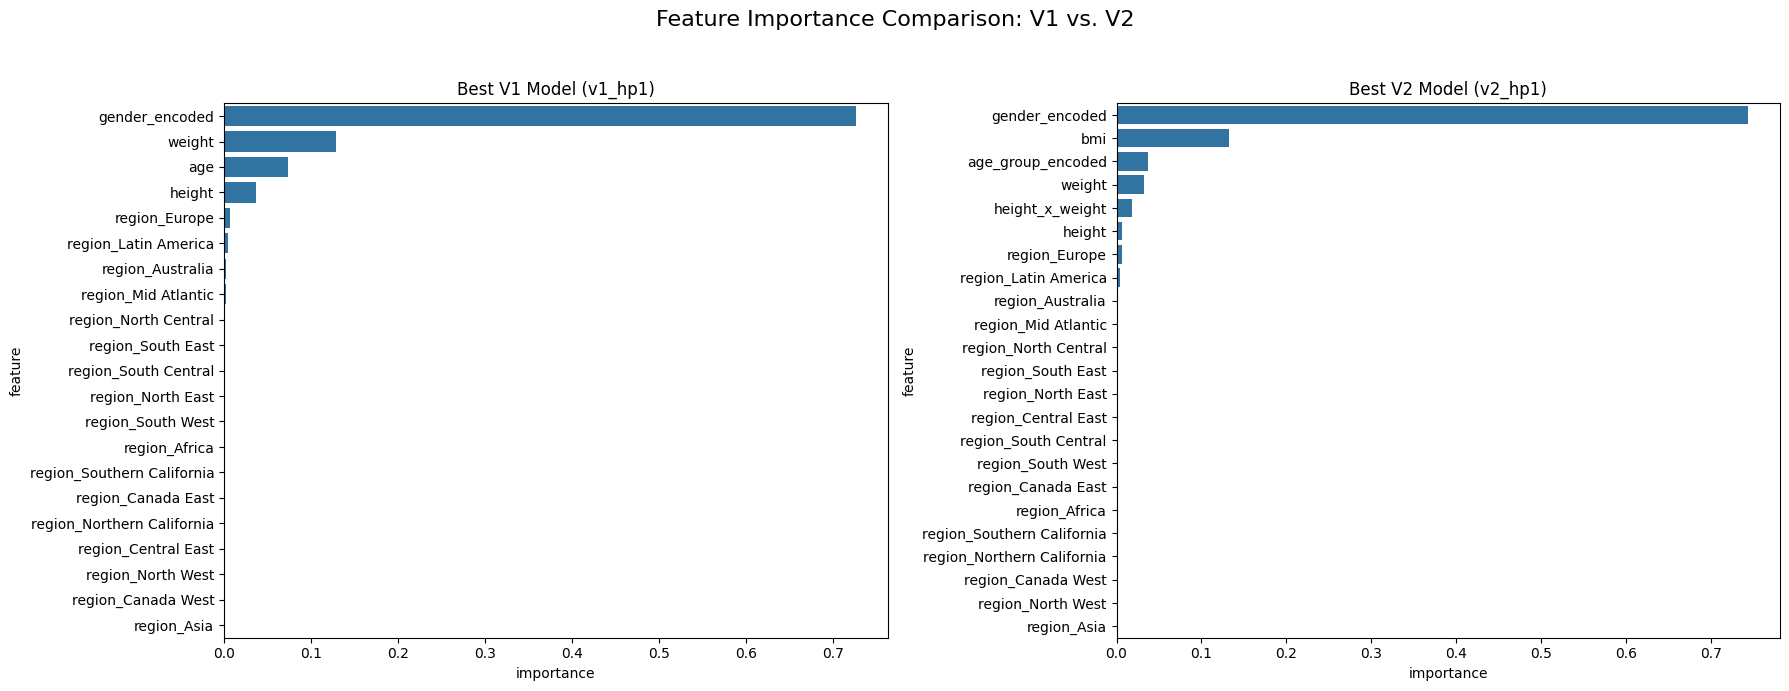

In [54]:
# --- Isolate the V1 results first ---
v1_results = results_df[results_df['feature_version'] == 'v1']
# Find the best run *within the V1 results*
best_v1_run = v1_results.loc[v1_results['rmse'].idxmin()]
model_v1 = trained_models[best_v1_run['run_name']]
features_v1, _ = experiment_datasets['v1']
importances_v1 = pd.DataFrame({
    'feature': features_v1.columns,
    'importance': model_v1.feature_importances_
}).sort_values('importance', ascending=False)


# --- Isolate the V2 results second ---
v2_results = results_df[results_df['feature_version'] == 'v2']
# Find the best run *within the V2 results*
best_v2_run = v2_results.loc[v2_results['rmse'].idxmin()]
model_v2 = trained_models[best_v2_run['run_name']]
features_v2, _ = experiment_datasets['v2']
importances_v2 = pd.DataFrame({
    'feature': features_v2.columns,
    'importance': model_v2.feature_importances_
}).sort_values('importance', ascending=False)


# --- Plotting code remains the same ---
fig, axes = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('Feature Importance Comparison: V1 vs. V2', fontsize=16)

# Plot for V1
sns.barplot(x='importance', y='feature', data=importances_v1, ax=axes[0])
axes[0].set_title(f"Best V1 Model ({best_v1_run['run_name']})")

# Plot for V2
sns.barplot(x='importance', y='feature', data=importances_v2, ax=axes[1])
axes[1].set_title(f"Best V2 Model ({best_v2_run['run_name']})")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('feature_importance_comparison.png')
plt.show()

/tmp/ipython-input-56-739680827.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


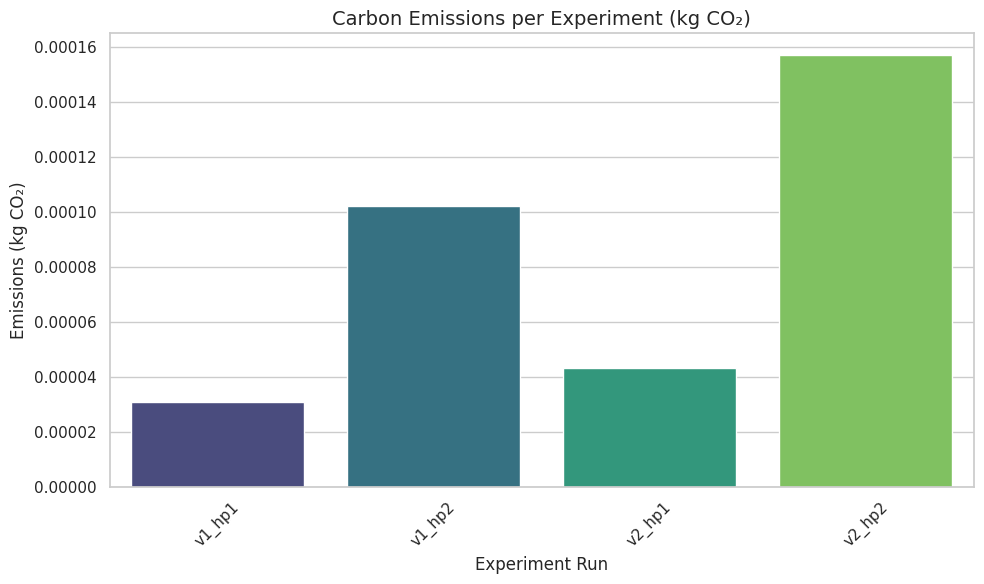

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

sns.barplot(
    x="run_name",
    y="emissions_kg",
    data=results_df,
    palette="viridis"
)

plt.title("Carbon Emissions per Experiment (kg CO₂)", fontsize=14)
plt.ylabel("Emissions (kg CO₂)")
plt.xlabel("Experiment Run")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('carbon_emission.png')
plt.show()
